In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import yaml
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

In [2]:
data_id = "zombie"

with open(f'my_data{data_id}.yaml') as f:
    data = yaml.safe_load(f)

In [3]:
concurrencies = [1,2,4,8,16,32,64]
samples = [1,10,100,1000,10000]
avoid_samples = []

In [4]:
#print(len(data))
#print(data.keys())

c1_s1: 3.1519999504089355
c1_s10: 18.233999967575073
c1_s100: 152.50400018692017
c1_s1000: 1244.3799998760223
c1_s10000: 11978.059000015259
c2_s1: 3.075000047683716
c2_s10: 11.894999980926514
c2_s100: 77.95799994468689
c2_s1000: 678.8710000514984
c2_s10000: 6236.075000047684
c4_s1: 3.5500001907348633
c4_s10: 8.517000198364258
c4_s100: 46.54900002479553
c4_s1000: 364.7339999675751
c4_s10000: 3171.452999830246
c8_s1: 5.578999996185303
c8_s10: 12.275999784469604
c8_s100: 26.05400013923645
c8_s1000: 194.63899993896484
c8_s10000: 1654.7020001411438
c16_s1: 5.304999828338623
c16_s10: 10.085000038146973
c16_s100: 17.94099998474121
c16_s1000: 105.64500021934509
c16_s10000: 888.9499998092651
c32_s1: 5.855999946594238
c32_s10: 11.467000007629395
c32_s100: 6.812000036239624
c32_s1000: 51.07800006866455
c32_s10000: 431.7810001373291
c64_s1: 7.5249998569488525
c64_s10: 10.442999839782715
c64_s100: 15.885999917984009
c64_s1000: 54.0770001411438
c64_s10000: 462.2630000114441


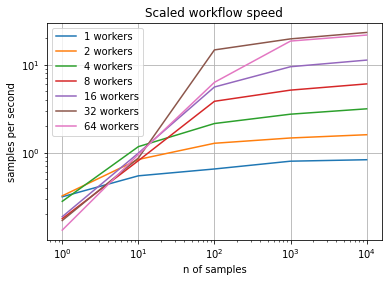

In [5]:
# FINAL
    
fig, ax = plt.subplots()
import re

concurrencies = [1,2,4,8,16,32,64]

for con in concurrencies:
    all_speeds = []
    for name, val in data.items():
        if f"c{con}_" in name and "start verify" in name:
            if "ERROR" in str(val):
                print("ERROR:" + name + " is " + str(val))
                break
            start_verify = val
            samples_verify = int(re.search("_s1\d*", name)[0].replace("_s", ""))
            
        if f"c{con}_" in name and "start run-workers" in name:
            samples_run_workers = int(re.search("_s1\d*", name)[0].replace("_s", ""))
            if samples_verify != samples_run_workers:
                print("some issue happened")
                continue
            start_run_workers = val
            tasks_time = start_verify - start_run_workers

            print(f"c{con}_s{samples_run_workers}: {tasks_time}")
            all_speeds.append((samples_run_workers / tasks_time))
        
    try:
        ax.plot(samples, all_speeds, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue
        
plt.xscale("log")
plt.yscale("log")
ax.legend()

ax.set(xlabel='n of samples', ylabel='samples per second',
               title='Scaled workflow speed')
ax.grid()

fig.savefig(f"figs/final__{data_id}.png", dpi=300)
plt.show()

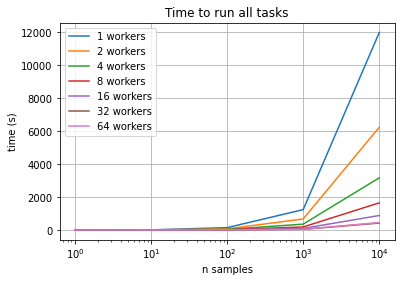

In [6]:
# TOTAL WF TIME
    
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data.items():
        if f"c{con}_" in name and "start verify" in name:
            if "ERROR" in str(val):
                print("ERROR:" + name + " is " + str(val))
                break
            start_verify = val
        if f"c{con}_" in name and "start run-workers" in name:
            start_run_workers = val
            all_task_times.append((start_verify - start_run_workers))
        
    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue
        
plt.xscale("log")
#plt.yscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='time (s)',
               title='Time to run all tasks')
ax.grid()

fig.savefig(f"figs/all_task_time__{data_id}.png", dpi=300)
plt.show()

skipped concurrency 64


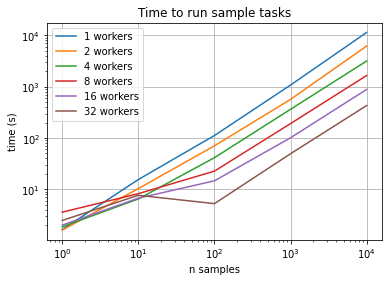

In [7]:
# SAMPLE TIME
    
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data.items():
        if f"c{con}_" in name and "start verify" in name:
            if "ERROR" in str(val):
                print("ERROR:" + name + " is " + str(val))
                break
            start_verify = val
        if f"c{con}_" in name and "start samp1" in name:
            if "ERROR" in str(val):
                print("ERROR" + name + " is " + str(val))
                break
            start_samp1 = val
            all_task_times.append((start_verify - start_samp1))
        
    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue
        
plt.xscale("log")
plt.yscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='time (s)',
               title='Time to run sample tasks')
ax.grid()

fig.savefig(f"figs/sample_task_time__{data_id}.png", dpi=300)
plt.show()

skipped concurrency 64: x and y must have same first dimension, but have shapes (5,) and (4,)


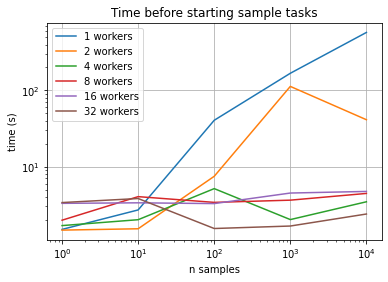

In [8]:
# TIME TO START WORKING ON TASKS
    
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data.items():
        stop = False
        for avoid in avoid_samples:
            if (name.endswith(f"_s{str(avoid)}")) or (f"_s{str(avoid)} " in name):
                stop = True
                break
        if stop:
            continue
        if f"c{con}_" in name and "start run-workers" in name:
            start_run_workers = val
        if f"c{con}_" in name and "start samp1" in name:
            if "ERROR" in str(val):
                print("ERROR" + name + " is " + str(val))
                break
            start_samp1 = val
            all_task_times.append((start_samp1 - start_run_workers))
        
    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}: {e}")
        continue
        
plt.xscale("log")
plt.yscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='time (s)',
               title='Time before starting sample tasks')
ax.grid()

fig.savefig(f"figs/pre_sample_time__{data_id}.png", dpi=300)
plt.show()

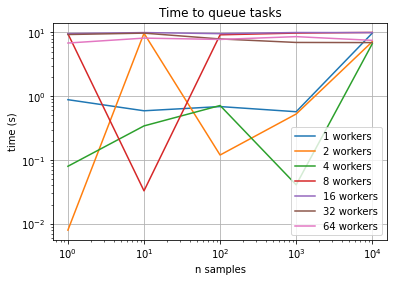

In [9]:
# TIME TO QUEUE ALL TASKS
    
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data.items():
        if f"c{con}_" in name and "merlin run" in name:
            queue_tasks = val
            all_task_times.append(queue_tasks)
        
    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue

plt.xscale("log")
plt.yscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='time (s)',
               title='Time to queue tasks')
ax.grid()

fig.savefig(f"figs/task_queue_time__{data_id}.png", dpi=300)
plt.show()

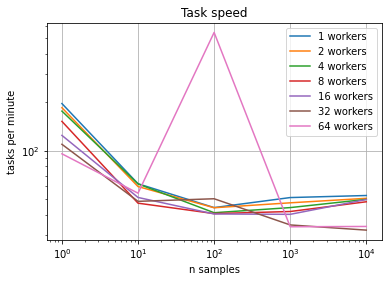

In [10]:
# TASK SPEED
    
fig, ax = plt.subplots()

for con in concurrencies:
    t_per_m = []
    for name, times in data.items():
        if f"c{con}_" in name and " " not in name:
            n_tasks = len(times)
            seconds = sum(times)
            mins = seconds / 60.0
            if mins == 0:
                t_per_m.append(0)
                continue
            tasks_per_min = n_tasks / mins
            t_per_m.append(tasks_per_min)
    ax.plot(samples, t_per_m, label=f"{con} workers")

plt.xscale("log")
plt.yscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='tasks per minute',
               title='Task speed')
ax.grid()

fig.savefig(f"figs/task_speed__{data_id}.png", dpi=300)
plt.show()

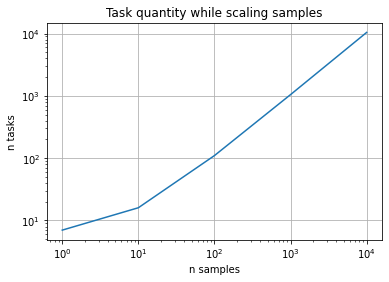

In [11]:

concurrency = 16

n_tasks = []
for sam in samples:
    for name, times in data.items():
        if name.endswith(f"_s{sam}") and name.startswith(f"c16_"):
            n_tasks.append(len(times))
            
fig, ax = plt.subplots()
ax.plot(samples, n_tasks)
plt.xscale("log")
plt.yscale("log")
ax.set(xlabel='n samples', ylabel='n tasks',
       title='Task quantity while scaling samples')
ax.grid()

#fig.savefig(f"figs/n_tasks3__{data_id}.png")
plt.show()

WITH OUTLIERS
81207 task times
84.18074792996049: max task time
1.3781296006196928: mean task time
2.2174709597608424: standard deviation

WITHOUT OUTLIERS
11403 task times
69804 task times
1.2237207450089045: max task time
1.0836215107374616: mean task time
0.04900701993773543: standard deviation


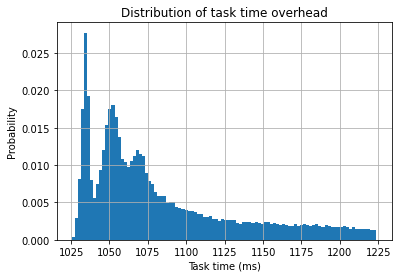

In [12]:
# OVERHEAD TYPE 1
# combining data from all concurrencies and sample quantities

def is_outlier(points, thresh=3):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

x = []
fig, ax = plt.subplots()

for name, times in data.items():
    if " " not in name:
        x += times

x = np.array(x)
#mad = stats.median_absolute_deviation(x)
outlier_mask = is_outlier(x)

print("WITH OUTLIERS")
print(f"{len(x)} task times")
print(f"{max(x)}: max task time")
print(f"{np.mean(x)}: mean task time")
print(f"{np.std(x)}: standard deviation")
outliers = x[outlier_mask]
non_outliers = x[~outlier_mask]
print("\nWITHOUT OUTLIERS")
print(f"{len(outliers)} task times")
print(f"{len(non_outliers)} task times")
print(f"{max(non_outliers)}: max task time")
print(f"{np.mean(non_outliers)}: mean task time")
print(f"{np.std(non_outliers)}: standard deviation")

n_bins = 100

ax.grid()
plt.hist(non_outliers*1000, bins=n_bins, density=True)
plt.xlabel('Task time (ms)')
plt.ylabel('Probability')
ax.set(title='Distribution of task time overhead')
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.savefig(f"figs/histogram__{data_id}.png", dpi=300)

plt.show()